In [1]:
import sys
# Add parent directory to the module search path
sys.path.append('../')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [3]:
# load the data
facialpoints_df = pd.read_csv('../data/KeyFacialPoints.csv')

In [4]:
facialpoints_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2140 entries, 0 to 2139
Data columns (total 31 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   left_eye_center_x          2140 non-null   float64
 1   left_eye_center_y          2140 non-null   float64
 2   right_eye_center_x         2140 non-null   float64
 3   right_eye_center_y         2140 non-null   float64
 4   left_eye_inner_corner_x    2140 non-null   float64
 5   left_eye_inner_corner_y    2140 non-null   float64
 6   left_eye_outer_corner_x    2140 non-null   float64
 7   left_eye_outer_corner_y    2140 non-null   float64
 8   right_eye_inner_corner_x   2140 non-null   float64
 9   right_eye_inner_corner_y   2140 non-null   float64
 10  right_eye_outer_corner_x   2140 non-null   float64
 11  right_eye_outer_corner_y   2140 non-null   float64
 12  left_eyebrow_inner_end_x   2140 non-null   float64
 13  left_eyebrow_inner_end_y   2140 non-null   float

In [5]:
facialpoints_df['Image'][0]

'238 236 237 238 240 240 239 241 241 243 240 239 231 212 190 173 148 122 104 92 79 73 74 73 73 74 81 74 60 64 75 86 93 102 100 105 109 114 121 127 132 134 137 137 140 139 138 137 137 140 141 143 144 147 148 149 147 147 148 145 147 144 146 147 147 143 134 130 130 128 116 104 98 90 82 78 85 88 86 80 77 87 108 111 115 128 133 188 242 252 250 248 251 250 250 250 235 238 236 238 238 237 238 242 241 239 237 233 215 195 187 156 119 103 93 78 68 73 75 75 72 75 70 61 66 77 91 96 106 108 113 120 125 131 134 138 135 138 139 145 144 144 142 140 141 141 148 147 150 149 152 151 149 150 147 148 144 148 144 146 146 143 139 128 132 135 128 112 104 97 87 78 79 83 85 83 75 75 89 109 111 117 117 130 194 243 251 249 250 249 250 251 237 236 237 238 237 238 241 238 238 238 241 221 195 187 163 124 106 95 81 68 70 73 73 72 73 69 65 74 82 94 103 110 111 119 127 135 140 139 144 144 145 143 143 143 146 144 144 147 146 148 147 150 146 147 150 150 149 147 147 144 147 144 149 146 144 144 144 140 131 133 133 125 110 

In [6]:
# Since values for the image is given as space separated string, we will need to separate the values using ' ' as separator.
# Then convert this into numpy array using np.fromstring and convert the obtained 1D array into 2D array of shape (96,96)
facialpoints_df['Image'] = facialpoints_df['Image'].apply(lambda x: np.fromstring(x, dtype= int, sep = ' ').reshape(96,96))

In [7]:
facialpoints_df['Image'][0]

array([[238, 236, 237, ..., 250, 250, 250],
       [235, 238, 236, ..., 249, 250, 251],
       [237, 236, 237, ..., 251, 251, 250],
       ...,
       [186, 183, 181, ...,  52,  57,  60],
       [189, 188, 207, ...,  61,  69,  78],
       [191, 184, 184, ...,  70,  75,  90]])

In [8]:
facialpoints_df['Image'][0].shape

(96, 96)

In [9]:
# Let's confirm that there are no null values 
facialpoints_df.isnull().sum()

left_eye_center_x            0
left_eye_center_y            0
right_eye_center_x           0
right_eye_center_y           0
left_eye_inner_corner_x      0
left_eye_inner_corner_y      0
left_eye_outer_corner_x      0
left_eye_outer_corner_y      0
right_eye_inner_corner_x     0
right_eye_inner_corner_y     0
right_eye_outer_corner_x     0
right_eye_outer_corner_y     0
left_eyebrow_inner_end_x     0
left_eyebrow_inner_end_y     0
left_eyebrow_outer_end_x     0
left_eyebrow_outer_end_y     0
right_eyebrow_inner_end_x    0
right_eyebrow_inner_end_y    0
right_eyebrow_outer_end_x    0
right_eyebrow_outer_end_y    0
nose_tip_x                   0
nose_tip_y                   0
mouth_left_corner_x          0
mouth_left_corner_y          0
mouth_right_corner_x         0
mouth_right_corner_y         0
mouth_center_top_lip_x       0
mouth_center_top_lip_y       0
mouth_center_bottom_lip_x    0
mouth_center_bottom_lip_y    0
Image                        0
dtype: int64

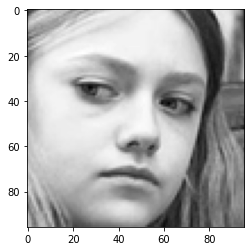

In [10]:
# Plot a random image from the dataset along with facial keypoints. 
i = np.random.randint(1, len(facialpoints_df))
plt.imshow(facialpoints_df['Image'][i],cmap='gray')

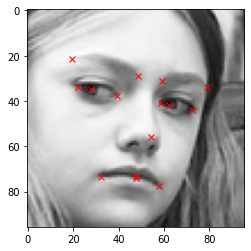

In [11]:
# The (x, y) coordinates for the 15 key features are plotted on top of the image
# Below is a for loop starting from index = 1 to 32 with step of 2
# In the first iteration j would be 1, followed by 3 and so on.
# since x-coordinates are in even columns like 0,2,4,.. and y-coordinates are in odd columns like 1,3,5,..
# we access their value using .loc command, which get the values for coordinates of the image based on the column it is refering to.
# in the first iteration df[i][j-1] would be df[i][0] refering the value in 1st column(x-coordinate) of the image in 'i' row.

plt.figure()
plt.imshow(facialpoints_df['Image'][i],cmap='gray')
for j in range(1,31,2):
        plt.plot(facialpoints_df.loc[i][j-1], facialpoints_df.loc[i][j], 'rx')

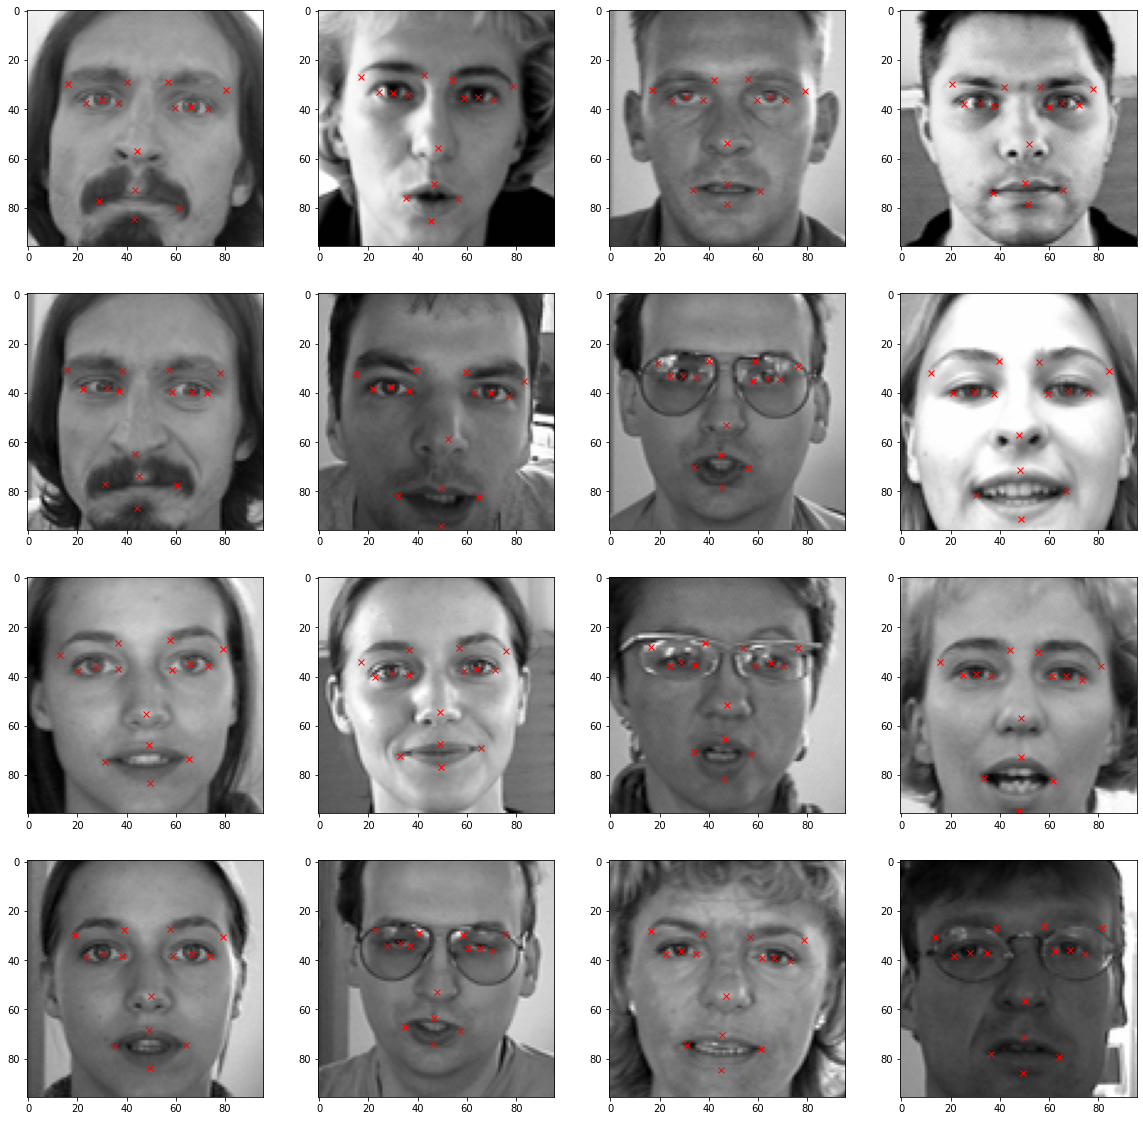

In [12]:
# Let's view more images in a grid format
fig = plt.figure(figsize=(20, 20))

for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1)    
    image = plt.imshow(facialpoints_df['Image'][i], cmap = 'gray')
    for j in range(1,31,2):
        plt.plot(facialpoints_df.loc[i][j-1], facialpoints_df.loc[i][j], 'rx')

In [13]:
# Create a new copy of the dataframe
import copy
facialpoints_df_copy = copy.copy(facialpoints_df)

In [14]:
# obtain the header of the DataFrame (names of columns) 

columns = facialpoints_df_copy.columns[:-1]
columns

Index(['left_eye_center_x', 'left_eye_center_y', 'right_eye_center_x',
       'right_eye_center_y', 'left_eye_inner_corner_x',
       'left_eye_inner_corner_y', 'left_eye_outer_corner_x',
       'left_eye_outer_corner_y', 'right_eye_inner_corner_x',
       'right_eye_inner_corner_y', 'right_eye_outer_corner_x',
       'right_eye_outer_corner_y', 'left_eyebrow_inner_end_x',
       'left_eyebrow_inner_end_y', 'left_eyebrow_outer_end_x',
       'left_eyebrow_outer_end_y', 'right_eyebrow_inner_end_x',
       'right_eyebrow_inner_end_y', 'right_eyebrow_outer_end_x',
       'right_eyebrow_outer_end_y', 'nose_tip_x', 'nose_tip_y',
       'mouth_left_corner_x', 'mouth_left_corner_y', 'mouth_right_corner_x',
       'mouth_right_corner_y', 'mouth_center_top_lip_x',
       'mouth_center_top_lip_y', 'mouth_center_bottom_lip_x',
       'mouth_center_bottom_lip_y'],
      dtype='object')

In [15]:
# Take a look at the pixel values of a sample image and see if it makes sense!
facialpoints_df['Image'][0]

array([[238, 236, 237, ..., 250, 250, 250],
       [235, 238, 236, ..., 249, 250, 251],
       [237, 236, 237, ..., 251, 251, 250],
       ...,
       [186, 183, 181, ...,  52,  57,  60],
       [189, 188, 207, ...,  61,  69,  78],
       [191, 184, 184, ...,  70,  75,  90]])

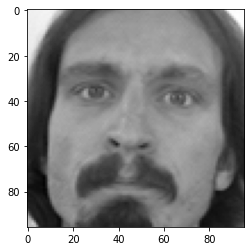

In [16]:
# plot the sample image
plt.imshow(facialpoints_df['Image'][0], cmap = 'gray')

In [17]:
# Now Let's flip the image column horizontally 
facialpoints_df_copy['Image'] = facialpoints_df_copy['Image'].apply(lambda x: np.flip(x, axis = 1))
# Now take a look at the flipped image and do a sanity check!
# Notice that the values of pixels are now flipped
facialpoints_df_copy['Image'][0]

array([[250, 250, 250, ..., 237, 236, 238],
       [251, 250, 249, ..., 236, 238, 235],
       [250, 251, 251, ..., 237, 236, 237],
       ...,
       [ 60,  57,  52, ..., 181, 183, 186],
       [ 78,  69,  61, ..., 207, 188, 189],
       [ 90,  75,  70, ..., 184, 184, 191]])

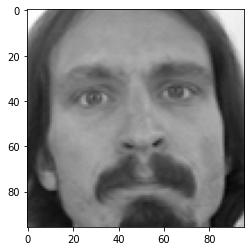

In [18]:
# Notice that the image is flipped now
plt.imshow(facialpoints_df_copy['Image'][0], cmap = 'gray')

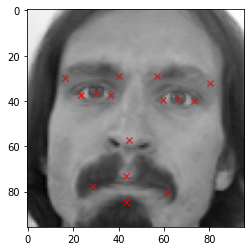

In [19]:
# View the Original image
plt.imshow(facialpoints_df['Image'][0],cmap='gray')
for j in range(1, 31, 2):
        plt.plot(facialpoints_df.loc[0][j-1], facialpoints_df.loc[0][j], 'rx')

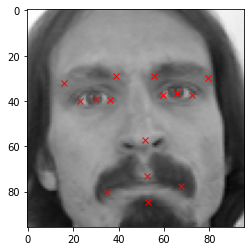

In [20]:
# Since we are flipping the images horizontally, y coordinate values would be the same
# X coordinate values only would need to change, all we have to do is to subtract our initial x-coordinate values from width of the image(96)
for i in range(len(columns)):
  if i%2 == 0:
    facialpoints_df_copy[columns[i]] = facialpoints_df_copy[columns[i]].apply(lambda x: 96. - float(x) )


# View the Horizontally flipped image
plt.imshow(facialpoints_df_copy['Image'][0], cmap='gray')
for j in range(1, 31, 2):
        plt.plot(facialpoints_df_copy.loc[0][j-1], facialpoints_df_copy.loc[0][j], 'rx')

In [21]:
# Concatenate the original dataframe with the augmented dataframe
facialpoints_df_augmented = np.concatenate((facialpoints_df,facialpoints_df_copy))
facialpoints_df_augmented.shape

(4280, 31)

In [22]:
facialpoints_df_augmented[0, -1]

array([[238, 236, 237, ..., 250, 250, 250],
       [235, 238, 236, ..., 249, 250, 251],
       [237, 236, 237, ..., 251, 251, 250],
       ...,
       [186, 183, 181, ...,  52,  57,  60],
       [189, 188, 207, ...,  61,  69,  78],
       [191, 184, 184, ...,  70,  75,  90]])

In [23]:
# Let's try to perform another image augmentation by randomly increasing images brightness
# We multiply pixel values by random values between 1 and 2 to increase the brightness of the image
# we clip the value between 0 and 255

import random

facialpoints_df_copy = copy.copy(facialpoints_df)
facialpoints_df_copy['Image'] = facialpoints_df['Image'].apply(lambda x:np.clip(random.uniform(1, 2) * x, 0.0, 255.0))
facialpoints_df_augmented = np.concatenate((facialpoints_df_augmented, facialpoints_df_copy))
facialpoints_df_augmented.shape

(6420, 31)

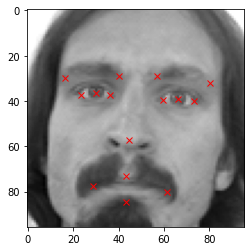

In [24]:
# Let's view image with increased brightness

plt.imshow(facialpoints_df_copy['Image'][0], cmap = 'gray')
for j in range(1, 31, 2):
        plt.plot(facialpoints_df_copy.loc[0][j-1], facialpoints_df_copy.loc[0][j], 'rx')

In [25]:
# Randomly decrease image brightness
# Multiply pixel values by random values between 0 and 1 to decrease the brightness of the image
# Clip the value between 0 and 255

facialpoints_df_copy = copy.copy(facialpoints_df)
facialpoints_df_copy['Image'] = facialpoints_df['Image'].apply(lambda x:np.clip(random.uniform(0, 0.2) * x, 0.0, 255.0))
facialpoints_df_augmented = np.concatenate((facialpoints_df_augmented, facialpoints_df_copy))
facialpoints_df_augmented.shape

(8560, 31)

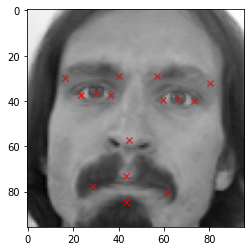

In [26]:
# Let's view image with increased brightness

plt.imshow(facialpoints_df_copy['Image'][0], cmap = 'gray')
for j in range(1, 31, 2):
        plt.plot(facialpoints_df_copy.loc[0][j-1], facialpoints_df_copy.loc[0][j], 'rx')

In [27]:
facialpoints_df_copy = copy.copy(facialpoints_df)
# Flip the image column vertically (note that axis = 0) 
facialpoints_df_copy['Image'] = facialpoints_df_copy['Image'].apply(lambda x: np.flip(x, axis = 0))

In [28]:
facialpoints_df['Image'][0]

array([[238, 236, 237, ..., 250, 250, 250],
       [235, 238, 236, ..., 249, 250, 251],
       [237, 236, 237, ..., 251, 251, 250],
       ...,
       [186, 183, 181, ...,  52,  57,  60],
       [189, 188, 207, ...,  61,  69,  78],
       [191, 184, 184, ...,  70,  75,  90]])

In [29]:
facialpoints_df_copy['Image'][0]

array([[191, 184, 184, ...,  70,  75,  90],
       [189, 188, 207, ...,  61,  69,  78],
       [186, 183, 181, ...,  52,  57,  60],
       ...,
       [237, 236, 237, ..., 251, 251, 250],
       [235, 238, 236, ..., 249, 250, 251],
       [238, 236, 237, ..., 250, 250, 250]])

In [30]:
# Since we are flipping the images vertically, x coordinate values would be the same
# y coordinate values only would need to change, all we have to do is to subtract our initial y-coordinate values from width of the image(96)
for i in range(len(columns)):
  if i%2 == 1:
    facialpoints_df_copy[columns[i]] = facialpoints_df_copy[columns[i]].apply(lambda x: 96. - float(x) )

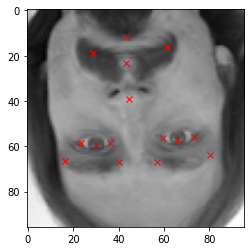

In [31]:
# View the Horizontally flipped image
plt.imshow(facialpoints_df_copy['Image'][0], cmap='gray')
for j in range(1, 31, 2):
        plt.plot(facialpoints_df_copy.loc[0][j-1], facialpoints_df_copy.loc[0][j], 'rx')

In [32]:
facialpoints_df_augmented = np.concatenate((facialpoints_df_augmented, facialpoints_df_copy))
facialpoints_df_augmented.shape

(10700, 31)

In [33]:
facialpoints_df_augmented[0, :30]

array([66.0335639098, 39.0022736842, 30.2270075188, 36.4216781955,
       59.582075188000005, 39.6474225564, 73.1303458647, 39.9699969925,
       36.3565714286, 37.3894015038, 23.4528721805, 37.3894015038,
       56.9532631579, 29.0336481203, 80.2271278195, 32.2281383459,
       40.2276090226, 29.0023218045, 16.3563789474, 29.6474706767,
       44.4205714286, 57.0668030075, 61.1953082707, 79.9701654135,
       28.6144962406, 77.38899248119999, 43.3126015038, 72.9354586466,
       43.1307067669, 84.4857744361], dtype=object)

In [34]:
import torch
from torch.utils.data import Dataset

class FaceDataset(Dataset):
    def __init__(self, data):
        self.data = data
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        # Get the features and image for the given index
        features = self.data[index, :30].astype(float)
        image = self.data[index, 30].astype(float)

        image = image / 255.
        
        return torch.from_numpy(features), torch.from_numpy(image)



In [35]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
train_data, test_data = train_test_split(facialpoints_df_augmented, test_size=0.2)

# Split the training data into training and validation sets
train_data, val_data = train_test_split(train_data, test_size=0.125)  # 0.125 x 0.8 = 0.1

# Now create the datasets
train_dataset = FaceDataset(train_data)
val_dataset = FaceDataset(val_data)
test_dataset = FaceDataset(test_data)

In [36]:
print(train_data.__len__())
print(val_data.__len__())
print(test_data.__len__())

7490
1070
2140


In [37]:
# Save the datasets
torch.save(train_dataset, '../data/train_data.pth')
torch.save(val_dataset, '../data/val_data.pth')
torch.save(test_dataset, '../data/test_data.pth')